This notebook explains all the steps taken to pre-process the unigram dataset.

In [39]:
import csv
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from scipy.interpolate import interp1d
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def tf(x):
    return 1+np.log10(x)

from itertools import groupby
from operator import itemgetter
import pickle as pkl
import re
def patternmaker(x):
    x=np.array(x.notnull())
    x=x.astype(int)
    #print(x)
    val = ''.join(map(str, x))
    #print(val)
    return val
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Introduction

The datasets are from the site http://www.ngrams.info/download_coha.asp.
For my experimentation, I wanted to see if this dataset could be a candidate for novel compound prediction.

The uni-gram dataset has the following fields -
1. count - Frequency of the uni-gram
2. unigram - The uni-gram
3. pos - The POS of the uni-gram, and
4. decade -The decade timestamp, where 1 is for 1810s, 2 for 1820s and so on.



For the initial trials I looked only into noun-noun compounds (I did perform experiments with adjective noun pairs, but many non compounds were returned).


In [40]:
unigram=pd.read_csv("1_pos_y_cs_y.txt",quotechar='"',delimiter="\t",quoting=csv.QUOTE_ALL,encoding='cp1252',skiprows=[1])
unigram.columns=['count','unigram','pos','decade']

In [41]:
pos_counts=unigram.pos.value_counts().to_frame()
pos_counts['perc']=round((pos_counts.pos/pos_counts.pos.sum())*100,3)
pos_counts.head(10)

,pos,perc
nn1,941021,28.739
jj,518965,15.849
np1,497243,15.186
nn2,402833,12.302
vv0,167451,5.114
vvg,116916,3.571
vvd,109428,3.342
vvn,107973,3.297
vvz,83968,2.564
vvi,83037,2.536


If we look at the pos tags, we see that there are about 280 of them. The POS tag description is provided on
http://ucrel.lancs.ac.uk/claws7tags.html. The large value of possible tags is due to the presence of “DITTO
Tags” (explanation found at the bottom of the webpage).

# Selection of only noun tags

From the tag explainations, nn, nn1 and nn2 are tags for common nouns (the '1' and '2' denote if the noun is singular or plural).

In [42]:
noun_tags=["nn","nn1","nn2"]
#adj_tags=["jj"]
unigram=unigram[unigram.pos.isin(noun_tags)]
nouns=dict.fromkeys(noun_tags,'noun')
#adj=dict.fromkeys(adj_tags,'adj')
unigram.head(10)

,count,unigram,pos,decade
390,3,aaaagh,nn1,16
401,6,AAAct,nn1,13
403,1,Aaah,nn1,11
404,1,Aaah,nn1,13
405,1,Aaah,nn1,18
424,1,Aaahh,nn1,13
425,1,Aaahh,nn1,15
426,4,Aaahhh,nn1,17
427,1,Aaahhh,nn1,18
428,1,aaahs,nn2,16


# Exploratory data analysis

As we see from the table above, the large number of tags should not be a concern as most have really small frequencies.

If we look at the count of words per decade, we see that the counts are increasing.
This should of course, come at no surprise.

In [43]:
decade_counts=unigram.decade.value_counts().to_frame()
decade_counts['perc']=round((decade_counts.decade/decade_counts.decade.sum())*100,3)
decade_counts

,decade,perc
18,96300,7.133
17,94589,7.006
15,93709,6.941
16,92347,6.840
13,91461,6.774
14,91456,6.774
12,91297,6.762
10,82825,6.135
11,82746,6.129
9,77059,5.708


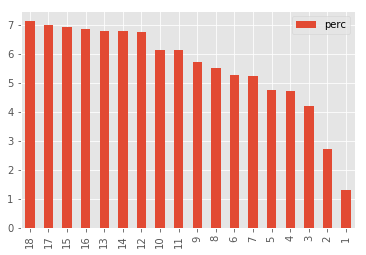

In [44]:
decade_counts.drop('decade',axis=1).plot.bar()

In [45]:
#possibile_tags=["nn","nn1","nn2","jj"]
noun_counts=pos_counts[pos_counts.index.isin(noun_tags)]
print(noun_counts)
print("\n Percentage of words that are nouns is ", round(noun_counts.perc.sum(),3) ,"%")

        pos   perc
nn1  941021 28.739
nn2  402833 12.302
nn     6256  0.191

 Percentage of words that are nouns is  41.232 %


# Lemmatization 

Lemmatization is performed on the dataset so that both singular and plural nouns get lemmatized to their common lemma form.

In [46]:
unigram.drop(['pos'],axis=1,inplace=True)

In [47]:
unigram.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1350110 entries, 390 to 3274396
Data columns (total 3 columns):
count      1350110 non-null int64
unigram    1350096 non-null object
decade     1350110 non-null int64
dtypes: int64(2), object(1)
memory usage: 41.2+ MB


In [48]:
unigram['unigram']=unigram['unigram'].str.lower()
unigram['word']=unigram['unigram'].apply(lambda x: lemmatizer.lemmatize(str(x)))
unigram.drop(['unigram'],axis=1,inplace=True)



display(unigram.head(10))
unigram.info()

,count,decade,word
390,3,16,aaaagh
401,6,13,aaact
403,1,11,aaah
404,1,13,aaah
405,1,18,aaah
424,1,13,aaahh
425,1,15,aaahh
426,4,17,aaahhh
427,1,18,aaahhh
428,1,16,aaahs


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1350110 entries, 390 to 3274396
Data columns (total 3 columns):
count     1350110 non-null int64
decade    1350110 non-null int64
word      1350110 non-null object
dtypes: int64(2), object(1)
memory usage: 41.2+ MB


Following operations were performed -

1. substitute all noun tags with 'noun'
2. merge the unigram and its tag together
3. reduce all words to lowercase

Some rows need to be merged after the tag class being simplified.

Also only words occuring at least 3 times in a decade are chosen.

In [49]:
unigram=unigram.groupby(['word','decade'])['count'].sum().to_frame()
unigram=unigram.reset_index(level=['word','decade'])
#unigram=unigram[unigram['count']>=10]
display(unigram.head(10))
unigram.info()

,word,decade,count
0,a,2,1
1,a,3,1
2,a,6,155
3,a,7,20
4,a,8,226
5,a,9,38
6,a,10,32
7,a,11,2
8,a,12,15
9,a,13,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873800 entries, 0 to 873799
Data columns (total 3 columns):
word      873800 non-null object
decade    873800 non-null int64
count     873800 non-null int64
dtypes: int64(2), object(1)
memory usage: 20.0+ MB


# Shallow to dense representation

We can now finally pivot the dataset (convert it from a shallow to dense represenation).


I have also added 3 extra columns which are,

**cf** : Collection frequency, which is the log of the sum of the term across decades, ie log(1+sum(term).

**presence** : Number of decades a term is present in.

**pattern** : A string that is of length 18. A 0 if the word was not present in the particular decade and 1 otherwise. Could be useful later on during the LSTM reprsentation.

Also, the decades are now suitably labeled.

In order to reduce bias against words with extremely high frequencies, all counts are logarithmically reduced.



In [50]:
unigram=unigram.pivot(index='word',columns='decade',values='count')
unigram.columns=['1810s','1820s','1830s','1840s','1850s','1860s','1870s','1880s','1890s','1900s','1910s','1920s','1930s','1940s','1950s','1960s','1970s','1980s']
#unigram = unigram.fillna(0)
#unigram[unigram.index.str.contains("['-]")==False]
unigram['cf']=unigram.sum(axis=1)
unigram['presence']=unigram.drop('cf',axis=1).count(axis=1)

#unigram['idf']=np.log10(18/unigram['presence'])
unigram['presence']=unigram["presence"].astype('category')
#unigram[unigram.columns[:-2]]=unigram[unigram.columns[:-2]].applymap(tf)
unigram['pattern']=unigram[unigram.columns[:-2]].apply(patternmaker,axis=1)
#unigram['term_weight']=unigram['cf']*unigram['idf']
display(unigram.head(10))
unigram.info()

,1810s,1820s,1830s,1840s,1850s,1860s,1870s,1880s,1890s,1900s,...,1920s,1930s,1940s,1950s,1960s,1970s,1980s,cf,presence,pattern
word,,,,,,,,,,,,,,,,,,,,,
a,nan,1.000,1.000,nan,nan,155.000,20.000,226.000,38.000,32.000,...,15.000,2.000,5.000,1.000,nan,nan,nan,498.000,12,011001111111111000
a'been,nan,2.000,nan,nan,nan,nan,nan,1.000,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,3.000,2,010000010000000000
a'bowl,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,3.000,nan,nan,nan,nan,3.000,1,000000000000010000
a'goin,nan,nan,nan,nan,nan,nan,nan,2.000,nan,1.000,...,nan,nan,nan,nan,nan,nan,nan,5.000,3,000000010110000000
a'here,nan,nan,nan,nan,3.000,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,3.000,1,000010000000000000
a'ku,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,4.000,nan,nan,nan,nan,nan,4.000,1,000000000000100000
a'nd,nan,nan,1.000,nan,1.000,nan,nan,nan,nan,1.000,...,1.000,nan,1.000,nan,nan,nan,nan,6.000,6,001010000111010000
a'r,nan,nan,nan,nan,nan,1.000,nan,14.000,5.000,1.000,...,nan,nan,nan,nan,nan,nan,nan,21.000,4,000001011100000000
a'ready,nan,nan,4.000,4.000,9.000,4.000,3.000,17.000,3.000,13.000,...,3.000,9.000,6.000,nan,1.000,1.000,1.000,93.000,15,001111111111110111


<class 'pandas.core.frame.DataFrame'>
Index: 168819 entries, a to zzo
Data columns (total 21 columns):
1810s       11567 non-null float64
1820s       24756 non-null float64
1830s       37561 non-null float64
1840s       41693 non-null float64
1850s       41987 non-null float64
1860s       47247 non-null float64
1870s       46482 non-null float64
1880s       49230 non-null float64
1890s       50551 non-null float64
1900s       53949 non-null float64
1910s       53423 non-null float64
1920s       58633 non-null float64
1930s       59406 non-null float64
1940s       58650 non-null float64
1950s       60170 non-null float64
1960s       58095 non-null float64
1970s       59930 non-null float64
1980s       60470 non-null float64
cf          168819 non-null float64
presence    168819 non-null category
pattern     168819 non-null object
dtypes: category(1), float64(19), object(1)
memory usage: 27.2+ MB


In [51]:
unigram.cf.sum()

63955407.0

In [38]:
unigram.to_csv('unigrams.csv',sep="\t")

# End of Report

All the details below are not important for the Novel Compound Generation and were for data analysis.

The NANs in the above dataset are when words were not present for the particular decade.
Even after certain pre-processing steps, the dataset appears to be messy due to presence of
1. Words such as “a-blowin_noun”,“a'throat_noun” (which might need to be parsed further),
2. Words such as “a'mighty_noun”, a'ready_noun (which seem to be missing letters)
3. words such as “zwei_noun” (which are not used in english).
There also exist several uni-grams that are compound nouns already.

In [13]:
#unigram.loc[["a-blowin_noun","a'throat_noun","a'mighty_noun","zwei_noun"]]
unigram.index.get_loc('bed_noun')

7917

There also exist several uni-grams that are compound nouns already.

In [14]:
unigram.shape

(108894, 21)

In [15]:
unigram.describe()

,1810s,1820s,1830s,1840s,1850s,1860s,1870s,1880s,1890s,1900s,1910s,1920s,1930s,1940s,1950s,1960s,1970s,1980s,cf
count,6083.000,12558.000,19461.000,21610.000,21344.000,24791.000,23901.000,26003.000,26495.000,28477.000,28107.000,30840.000,30554.000,30162.000,31315.000,30725.000,31638.000,33478.000,108894.000
mean,2.126,2.265,2.266,2.255,2.255,2.206,2.240,2.229,2.226,2.222,2.230,2.240,2.224,2.234,2.230,2.240,2.232,2.234,2.229
std,0.556,0.702,0.741,0.745,0.746,0.723,0.733,0.733,0.732,0.731,0.735,0.743,0.739,0.740,0.734,0.734,0.730,0.732,0.852
min,1.477,1.477,1.477,1.477,1.477,1.477,1.477,1.477,1.477,1.477,1.477,1.477,1.477,1.477,1.477,1.477,1.477,1.477,1.477
25%,1.699,1.699,1.699,1.602,1.602,1.602,1.602,1.602,1.602,1.602,1.602,1.602,1.602,1.602,1.602,1.602,1.602,1.602,1.602
50%,2.000,2.079,2.041,2.041,2.041,1.954,2.041,2.000,2.000,2.000,2.000,2.000,2.000,2.000,2.000,2.041,2.000,2.000,1.954
75%,2.491,2.716,2.716,2.699,2.699,2.607,2.653,2.633,2.633,2.633,2.643,2.653,2.623,2.643,2.633,2.643,2.633,2.643,2.591
max,4.245,4.996,5.291,5.443,5.403,5.416,5.463,5.537,5.536,5.610,5.596,5.620,5.561,5.536,5.544,5.541,5.525,5.488,6.726


From the description table above, we see how higher counts can be biased towards the importance of a term.

Hence another transformation is performed - Raw frequencies to term frequencies.


In [16]:
pattern_counts=unigram.pattern.value_counts().to_frame()
pattern_counts['perc']=round((pattern_counts['pattern']/pattern_counts['pattern'].sum())*100,3)
pattern_counts.sort_index(inplace=True)
pattern_counts

,pattern,perc
000000000000000001,6915,6.350
000000000000000010,4724,4.338
000000000000000011,975,0.895
000000000000000100,4251,3.904
000000000000000101,314,0.288
000000000000000110,367,0.337
000000000000000111,569,0.523
000000000000001000,4342,3.987
000000000000001001,269,0.247
000000000000001010,225,0.207


In [17]:
#xlabels=pattern_counts[pattern_counts.pattern>4000].index
#xlabels

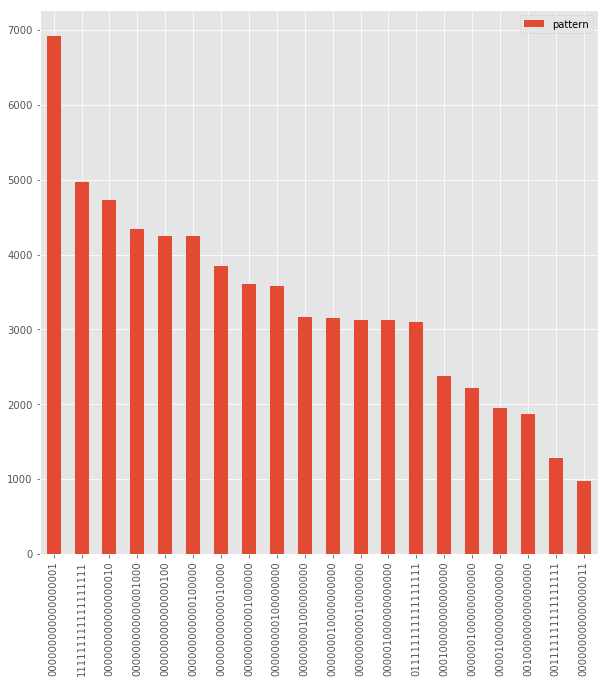

In [18]:
pattern_counts.sort_values('perc', ascending=False).head(20).drop('perc',axis=1).plot.bar(figsize=(10,10))

In [19]:
#fig, ax = plt.subplots()
#pattern_counts.pattern.plot(ax=ax,figsize=(15,15),rot=45)
#tick_idx = plt.xticks()[0]
#year_labels = df.years[tick_idx].values
#ax.xaxis.set_ticklabels(xlabels)

#pattern_counts.pattern.plot(figsize=(15,15),xticks=xlabels)

In [20]:
pattern_counts.perc[pattern_counts.perc>=5.0].sum()

6.35

From the table above we see that that log normalization has helped in reducing the variation of the terms across the decades.

There are still 357971 possible unigrams in the dataset, and that would mean we would theoritically 357971*357971 rows in the bigram dataset.

It then makes sence to figure out ways of eliminating uni-grams that are less "informative".

A unigram could be considered to be "informative" if it -

1. Occurs consistently across the decades. (Given by the presence column)
2. Has a good frequency accoess the decades. (Given by the cf column)


Given below are graphs and more statistics that hopefully could help you in deciding the correct amount of unigrams that should be selected. 

In [21]:
decade_presence=unigram.presence.value_counts().to_frame()
decade_presence['perc']=round((decade_presence.presence/decade_presence.presence.sum())*100,3)
decade_presence.sort_index(inplace=True)
decade_presence

,presence,perc
1,57433,52.742
2,12022,11.040
3,6374,5.853
4,4185,3.843
5,3281,3.013
6,2605,2.392
7,2232,2.050
8,1864,1.712
9,1707,1.568
10,1404,1.289


The table above and the plot below show how the proportion of words changes w.r.t the Presence column.

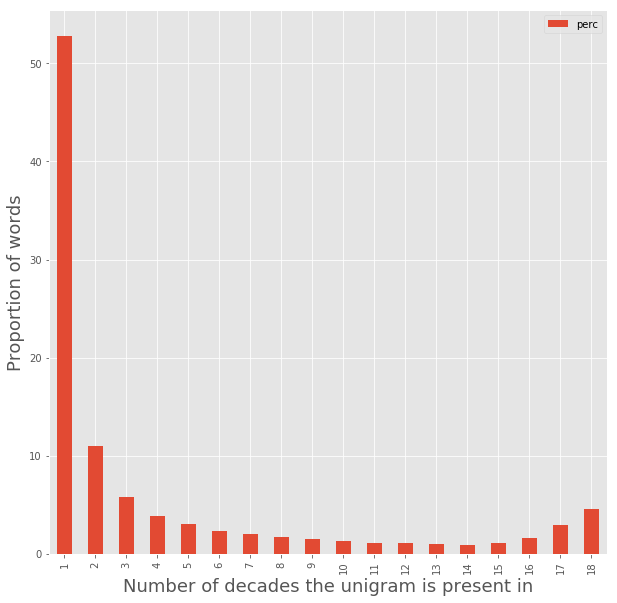

In [22]:
fig, ax = plt.subplots()
decade_presence.drop('presence',axis=1).plot.bar(ax=ax,figsize=(10,10))
plt.xlabel('Number of decades the unigram is present in', fontsize=18)
plt.ylabel('Proportion of words', fontsize=18)
plt.show()

What we could decipher from above is that several words only belong in 4 of fewer decades. Such words could be removed as they might be helpful in discovering future compounds.

You could make a call on how important this statistic is.

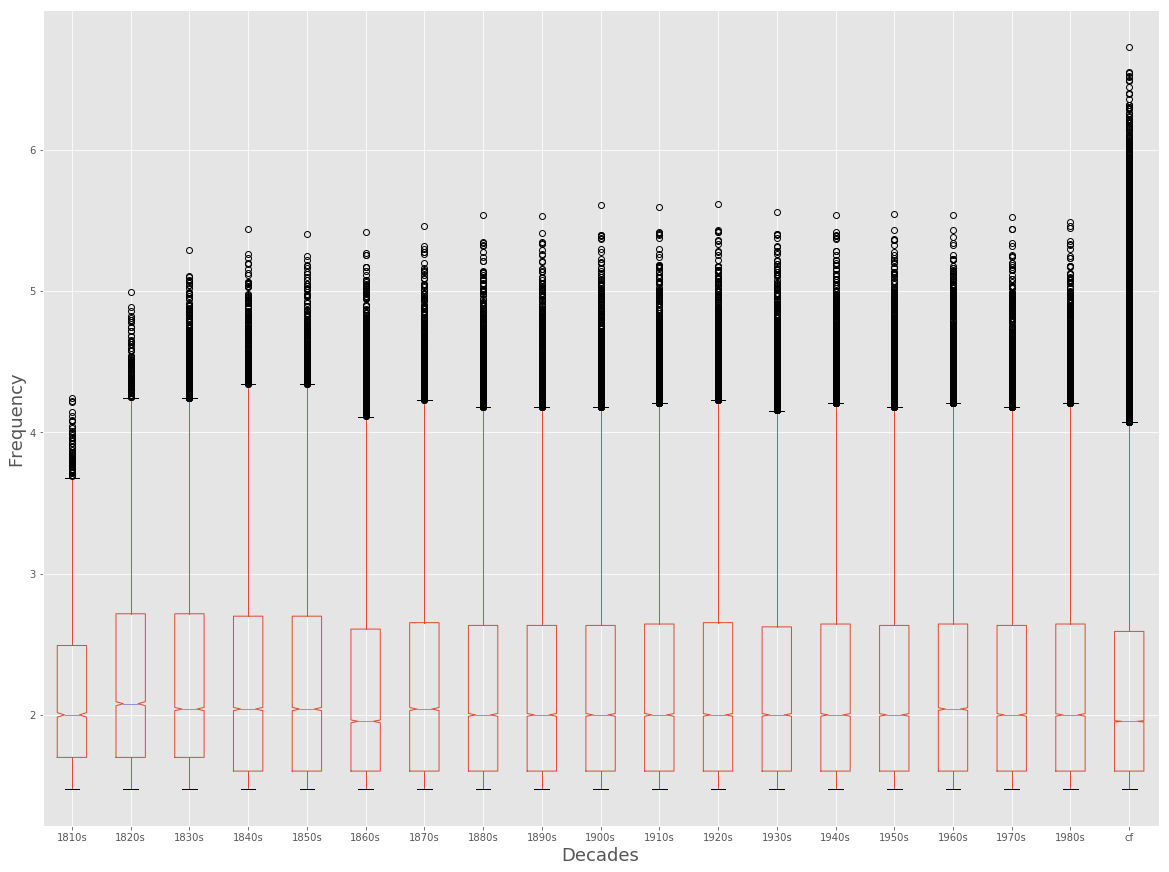

In [23]:

fig, ax = plt.subplots()
unigram.drop('presence',axis=1).plot.box(ax=ax,showfliers=True,figsize=(20,15),legend =True,notch=True)

plt.xlabel('Decades', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()


From the boxplot of Decades vs. the Frequency of a unigram we can see the visual represention of the description of the unigram dataset.

The cf (Collection Frequency) column encompasses the information of a unigram for all the decades, and hence should be useful in selecting the possible unigrams.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015ED3960CF8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000015ED3EE38D0>]], dtype=object)

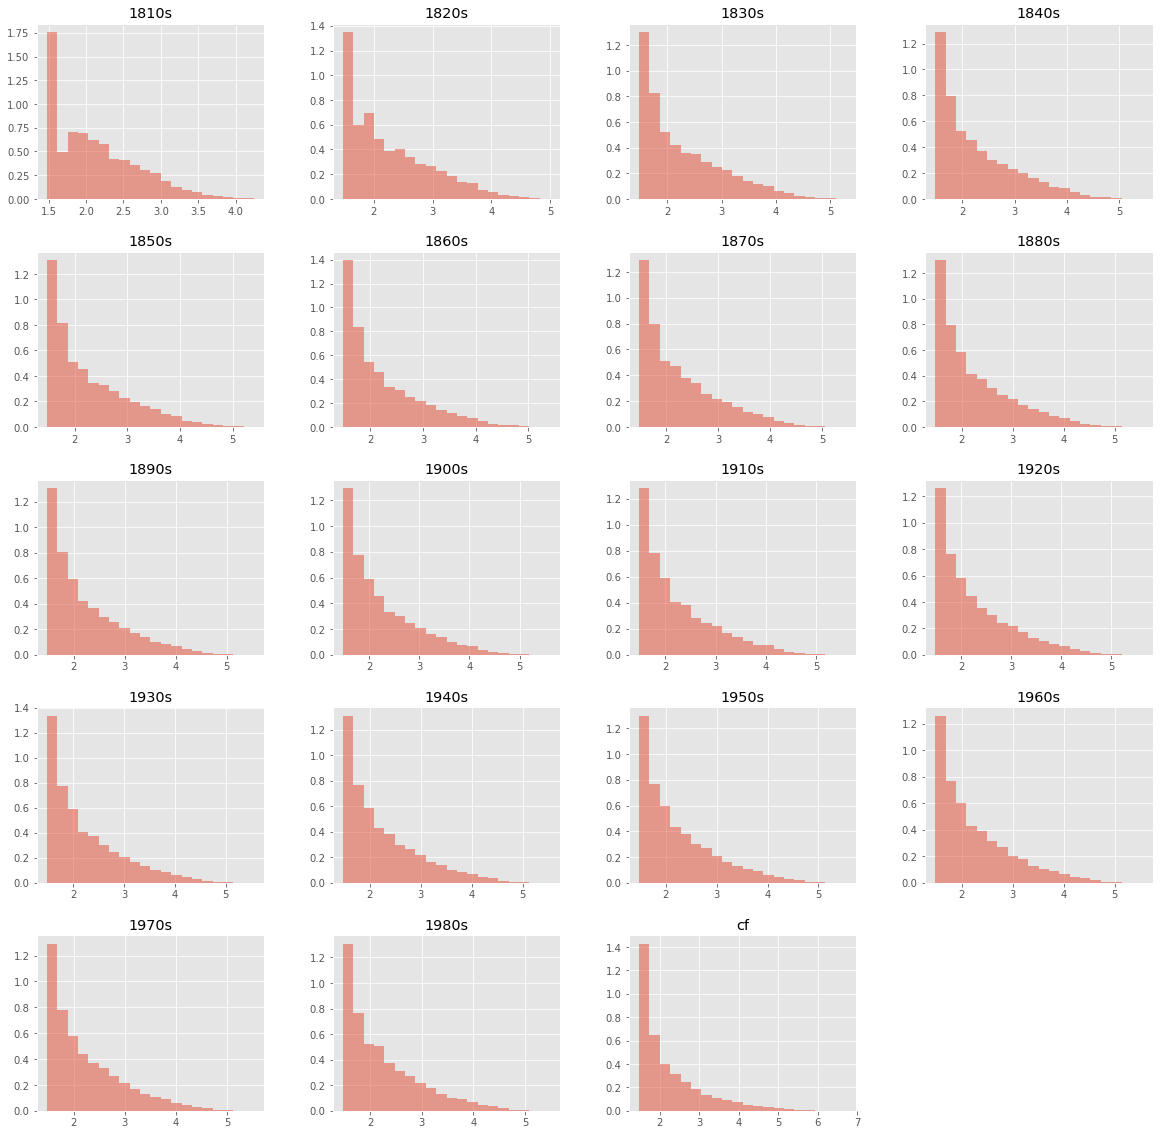

In [24]:
unigram.hist(figsize=(20,20),alpha=0.5,bins=20,normed=1)

The histograms do not seem to highlight anything out of the blue.

The graphs below are maybe where Lonneke could give her perpective.

Each individual graph shows how the Collection Frequency varies w.r.t the Presence column.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015ED3FAC828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000015ED5350E48>]], dtype=object)

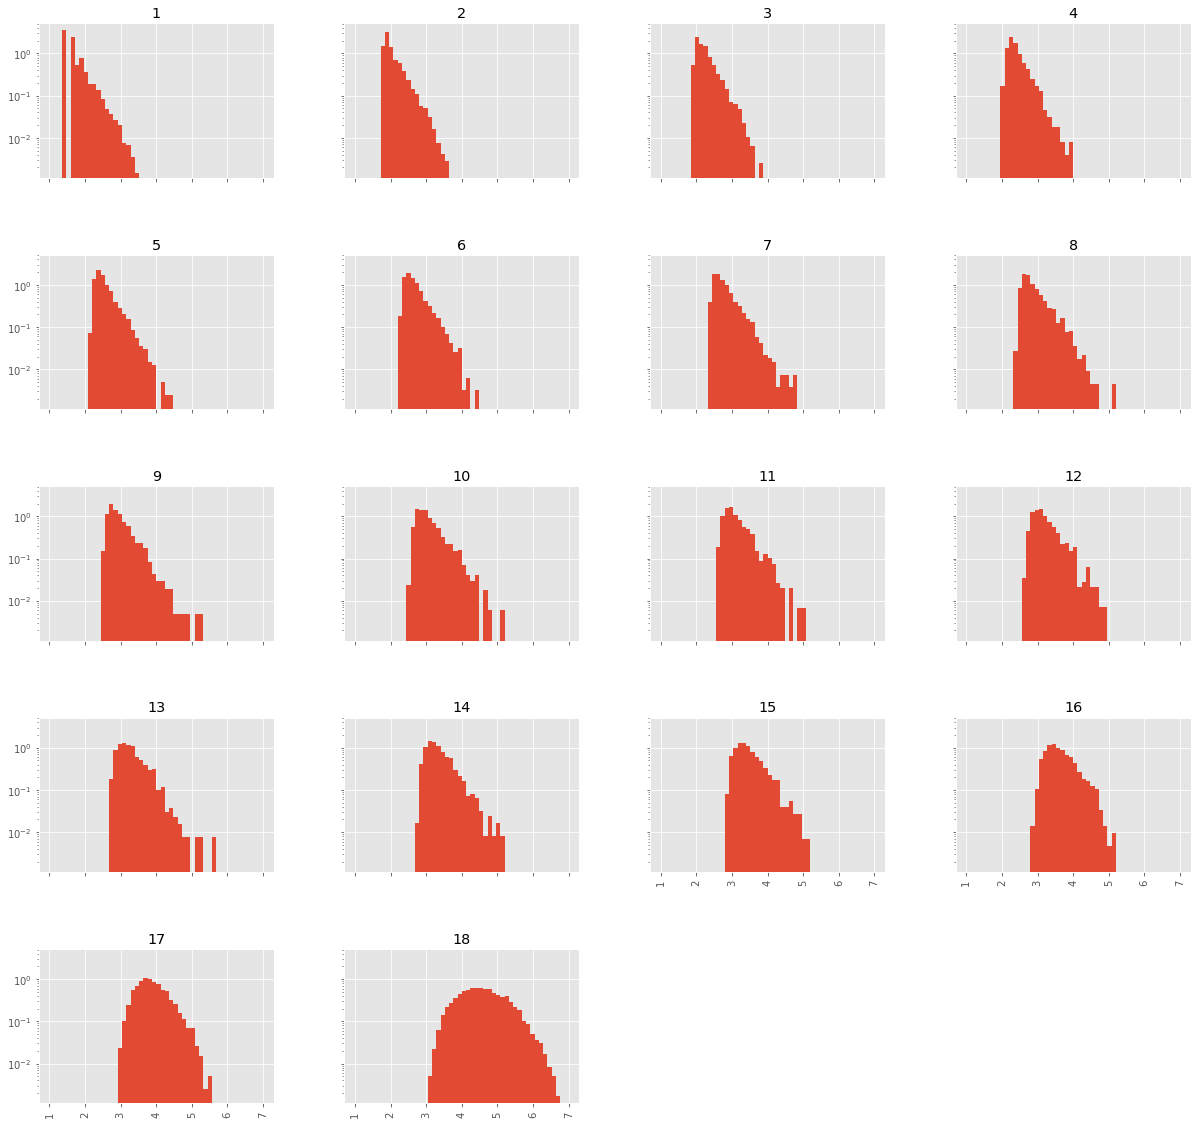

In [25]:
unigram.hist(by= 'presence',column ='cf', figsize=(20, 20),bins=50,sharex=True,log=True,sharey=True,normed=True,range=(1,7))

In both the Histograms and the Boxplots, following are observed -

1. The distribution of the cf spreads out (becomes more normal as well) as the presence of a unigram increases.
2. The median and the IQR (the region represented by the box in the bloxplot) keep shifting higher.



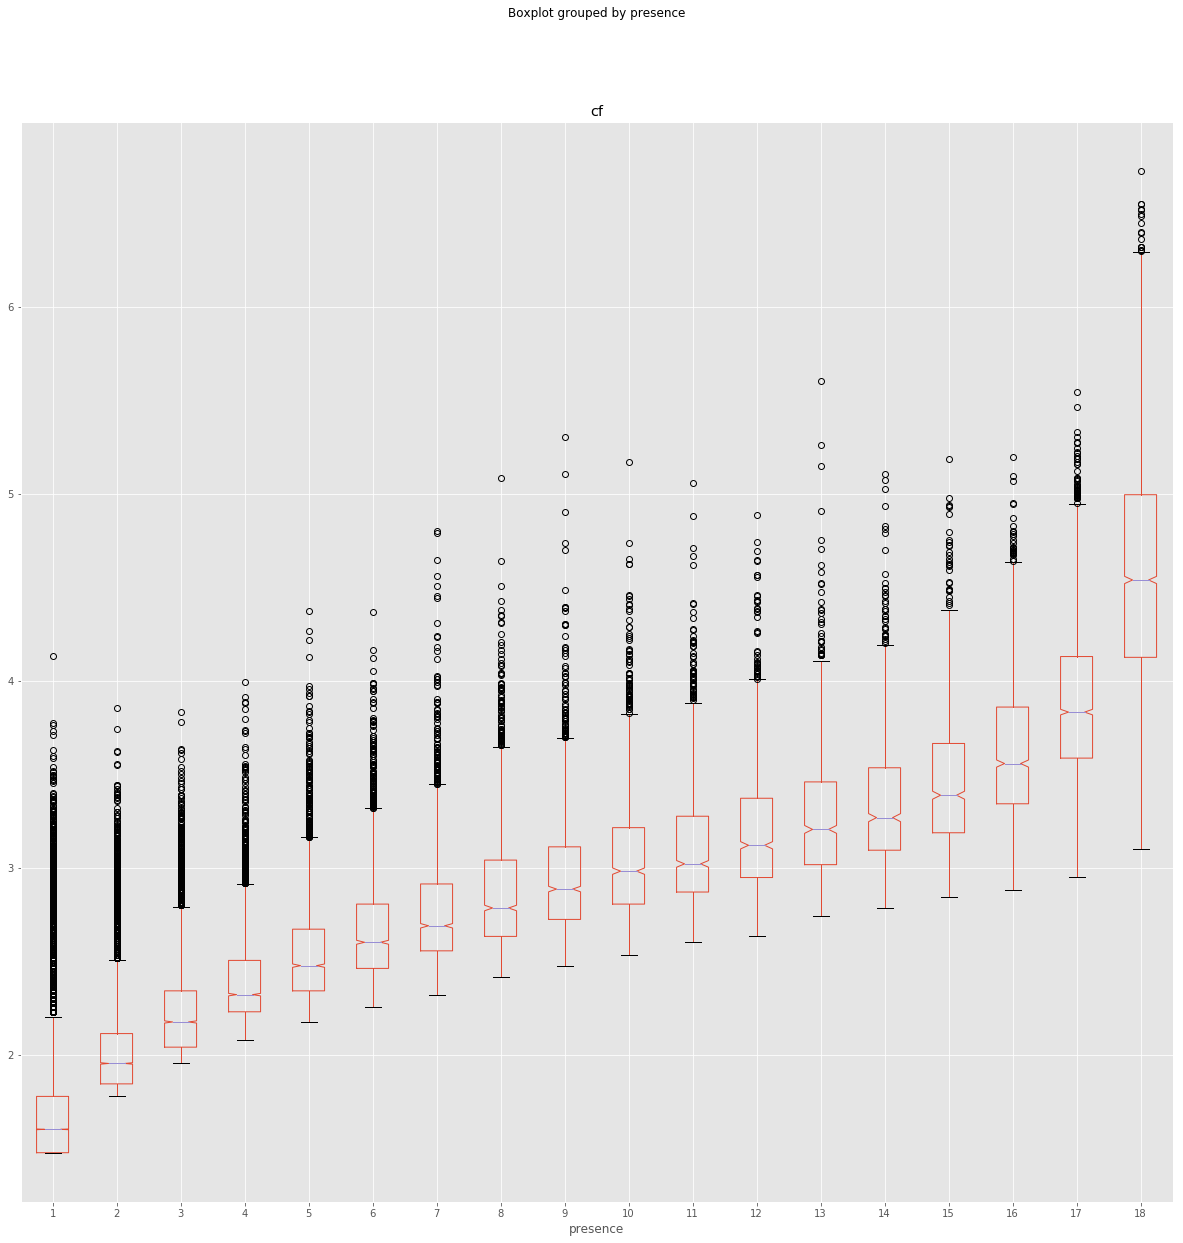

In [26]:
#fig, ax = plt.subplots()
unigram.boxplot(by= 'presence',column ='cf',figsize=(20, 20),notch=True)
#plt.figure(figsize=(20, 20))
#plt.axhline(y=2, color='r', linestyle='-')
#plt.xlabel('Presence', fontsize=18)
#plt.ylabel('Collection Frequency', fontsize=18)

#plt.show()

The boxplots could help you in deciding on the cutoff value for the collection frequency. 

For example, if you wish to select unigrams that have a collection frequency > 2 and have been seen in 4 or more decades, then you would the graph below.


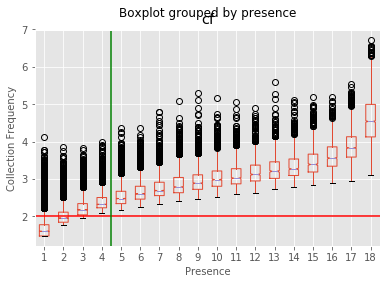

In [27]:
fig, ax = plt.subplots()
unigram[['presence','cf']].boxplot(ax=ax,by= 'presence',figsize=(20,20),notch=True)
#plt.figure(figsize=(20, 20))
plt.axhline(y=2, color='r', linestyle='-')
plt.axvline(x=4.5,color='g',linestyle='-')
plt.xlabel('Presence', fontsize=10)
plt.ylabel('Collection Frequency', fontsize=10)

plt.show()

The fact that the distributions are changing should not too suprising, as it makes sence that the cf inscreases as the decades go by.

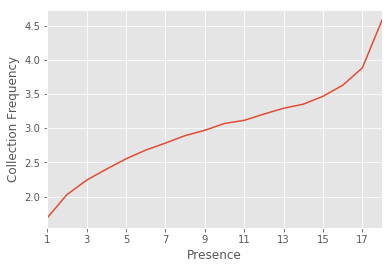

In [28]:
ax=unigram.groupby('presence')['cf'].mean().plot()
ax.set(xlabel="Presence", ylabel="Collection Frequency")

I hope all the above statistics helped you understand the complexity of the problem.

Now, if we were to select a cut-off for the collection frequency value as we did before, we would get the new reduced dataset as below. 

In [29]:
newunigram=unigram[((unigram.cf>2.0)==True)  & (unigram.presence.isin([1,2,3,4])==False)]
newunigram

,1810s,1820s,1830s,1840s,1850s,1860s,1870s,1880s,1890s,1900s,...,1920s,1930s,1940s,1950s,1960s,1970s,1980s,cf,presence,pattern
word,,,,,,,,,,,,,,,,,,,,,
a'ready_noun,nan,nan,1.602,1.602,1.954,1.602,1.477,2.230,1.477,2.114,...,1.477,1.954,1.778,nan,nan,nan,nan,2.954,12,001111111111110000
a-bomb_noun,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,1.845,2.771,2.322,2.000,2.204,3.053,5,000000000000011111
a-callin_noun,nan,nan,nan,nan,nan,nan,1.602,1.477,nan,1.477,...,nan,1.477,nan,nan,nan,nan,nan,2.230,5,000000110110100000
a-cryin_noun,nan,nan,nan,nan,nan,nan,1.477,nan,1.845,nan,...,nan,1.845,1.477,nan,nan,nan,nan,2.380,5,000000101010110000
a-fishing_noun,nan,nan,nan,1.699,2.114,2.000,1.778,1.845,2.041,2.041,...,2.000,nan,nan,nan,nan,nan,nan,2.898,9,000111111111000000
a-gettin_noun,nan,nan,nan,nan,nan,nan,nan,1.477,1.845,1.477,...,nan,1.778,2.176,2.230,nan,nan,1.903,2.792,8,000000011110111001
a-gittin_noun,nan,nan,nan,nan,nan,nan,1.845,1.903,2.176,1.845,...,2.041,nan,2.041,nan,nan,nan,nan,2.792,7,000000111111010000
a-hangin_noun,nan,nan,nan,nan,nan,nan,1.477,1.954,1.778,nan,...,nan,nan,nan,1.778,nan,nan,nan,2.447,5,000000111010001000
a-huntin_noun,nan,nan,nan,nan,nan,nan,1.845,1.699,nan,2.000,...,1.699,nan,nan,1.954,nan,nan,nan,2.556,5,000000110101001000


In [30]:
pattern_counts=newunigram.pattern.value_counts().to_frame()
pattern_counts['perc']=round((pattern_counts['pattern']/pattern_counts['pattern'].sum())*100,3)
pattern_counts.sort_index(inplace=True)
pattern_counts

,pattern,perc
000000000000011111,474,1.641
000000000000101111,108,0.374
000000000000110111,41,0.142
000000000000111011,40,0.139
000000000000111101,47,0.163
000000000000111110,56,0.194
000000000000111111,492,1.704
000000000001001111,40,0.139
000000000001010111,16,0.055
000000000001011011,16,0.055


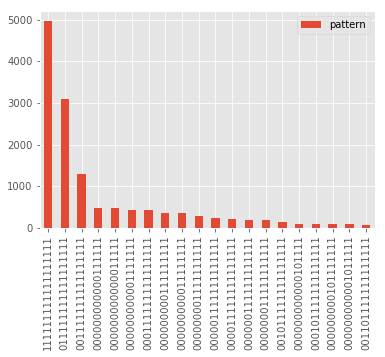

In [31]:
pattern_counts.sort_values('perc', ascending=False).head(20).drop('perc',axis=1).plot.bar()

As you can see, the dataset is reduced to 1/3rd its original size.

We, however are still left with unsuitable unigrams such as "a-blaze_adj", "a'mighty_noun",etc.

You can access all the unigrams in the dataset using the code below (they are grouped by the first letter of the unigram)

In [32]:
unigram_list=newunigram.index.tolist()
unigram_dict={}
for letter, words in groupby(sorted(unigram_list), key=itemgetter(0)):
    #print(letter)
    for word in words:
        if letter not in unigram_dict:
            unigram_dict[letter]=list()
            unigram_dict[letter].append(word)
        else:
            unigram_dict[letter].append(word)


In [33]:
for letter in unigram_dict:
    print("There are ",len(unigram_dict[letter]),"terms with the letter ", letter)

There are  254 terms with the letter  k
There are  307 terms with the letter  j
There are  1059 terms with the letter  g
There are  52 terms with the letter  z
There are  2973 terms with the letter  c
There are  582 terms with the letter  n
There are  979 terms with the letter  e
There are  1350 terms with the letter  r
There are  616 terms with the letter  o
There are  963 terms with the letter  i
There are  1568 terms with the letter  a
There are  953 terms with the letter  w
There are  1817 terms with the letter  b
There are  1555 terms with the letter  d
There are  123 terms with the letter  y
There are  132 terms with the letter  q
There are  3528 terms with the letter  s
There are  1267 terms with the letter  h
There are  1626 terms with the letter  t
There are  448 terms with the letter  v
There are  14 terms with the letter  x
There are  314 terms with the letter  u
There are  2321 terms with the letter  p
There are  1061 terms with the letter  l
There are  1643 terms with the 

You could now try to look through these terms and if any outliers exist. 

For example, if we look at  some unigrams that start with a 'b' we see there exist outliers which -

1. Have symbols in between the words (b'nai_noun,b'y_noun) . These must be errors in reading the documents during OCR step
2. Are already compounds (baby-blue_adj,baby-clothes_noun,back-and-forth_adj). 




I hope all of the above steps and explained helped you in understanding the task.

So, to reiterate your task would be to remove of unwanted unigrams that are present in the dataset.
They could be due 
1. Errors during scanning of the document, 
2. Unigrams that are not in fact, unigrams
3. Unigrams that occur too infrequently and/or in too few decades

In [34]:
unigram_dict['b']

["b'ar_noun",
 "b'ilin_noun",
 "b'lieve_noun",
 "b'y_noun",
 "b'ys_noun",
 'ba_noun',
 'babble_noun',
 'babbler_noun',
 'babbling_noun',
 'babby_noun',
 'babcock_noun',
 'babe_noun',
 'babel_noun',
 'babette_noun',
 'baboon_noun',
 'baby-house_noun',
 'baby-sitter_noun',
 'baby-talk_noun',
 'baby_noun',
 'babyhood_noun',
 'babylon_noun',
 'babylonian_noun',
 'bac_noun',
 'bacardi_noun',
 'baccarat_noun',
 'bacchant_noun',
 'bacco_noun',
 'bach_noun',
 'bache_noun',
 'bachelor_noun',
 'bachelorhood_noun',
 'bacillus_noun',
 'back-bone_noun',
 'back-door_noun',
 'back-ground_noun',
 'back-log_noun',
 'back-stairs_noun',
 'back-yard_noun',
 'back_noun',
 'backache_noun',
 'backboard_noun',
 'backbone_noun',
 'backcourt_noun',
 'backdoor_noun',
 'backdrop_noun',
 'backer_noun',
 'backfield_noun',
 'backgammon_noun',
 'background_noun',
 'backin_noun',
 'backing_noun',
 'backlash_noun',
 'backlog_noun',
 'backroom_noun',
 'backside_noun',
 'backslider_noun',
 'backsliding_noun',
 'backstair

In [35]:
newunigram.to_csv("unigrams.csv")